# 1. Preprocessing and Cleaning of data

True
Intial total length of the dataset 124384
Removing Na records
NA records removed:  0
Removing Duplicates records
duplicates records removed:  946
converting string small case
Removing numbers...
Numbers are removed
Removing single character words
Removing single character words
Removing links
Links are removed
Removing punchuation and special characters
Puntuations removed...
Removing stop words...
Stop words removed...
Removing non english words
Non english words removed
Removing tweets having words less than 3 words
tweets having words less than 3 words are removed...
word count less than 3 records removed:  43078
new data started writting in new csv file preprocessed_data.csv...
clean data is written on preprocessed_data.csv


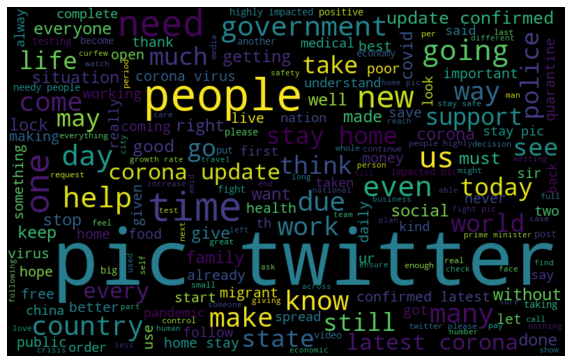

In [169]:
import pandas as pd
import numpy as np
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#stops words
stop = stopwords.words('english')
#english words
english_word = set(nltk.corpus.words.words())
print('naam' in english_word)
#reading the dataset in csv file
df= pd.read_csv('hashtag_data.csv')
to_drop=['conversation_id','timezone','name','place','mentions','urls','photos',
         'cashtags','link','retweet','quote_url','video','near','geo','source',
         'user_rt_id','user_rt','retweet_id','reply_to','retweet_date','translate','trans_src',
         'trans_dest']

#drop columns
df.drop(to_drop, inplace=True, axis=1)
totallen=len(df)
print("Intial total length of the dataset",len(df))

#droping na records
print("Removing Na records")
df = df.dropna()
df = df.reset_index(drop=True)
print("NA records removed: ",totallen-len(df) )

#droping dulplicats records
print("Removing Duplicates records")
df = df.drop_duplicates()
#reset index after dropping
df = df.reset_index(drop=True)
print("duplicates records removed: ",totallen-len(df) )

print("converting string small case")
#convert text to small case
df['tweet'] = df['tweet'].str.lower()

print("Removing numbers...")
#removes numbers from text
df['tweet'] = df['tweet'].str.replace('\d+', '')
print("Numbers are removed")

print("Removing single character words")
#remove single character chracter
df['tweet'] = df['tweet'].replace(re.compile(r"(^| ).( |$)"), "")
print("Removing single character words")

print("Removing links")
#removes links and urls
df['tweet'] = df['tweet'].replace(re.compile(r'((www\.[\S]+)|(https?://[\S]+))'),"")
print("Links are removed")

print("Removing punchuation and special characters")
#removes puntuation
df['tweet'] = df['tweet'].str.replace('[^\w\s]',' ').str.replace('\s\s+', '')
print("Puntuations removed...")

print("Removing stop words...")
#remove stop words
df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print("Stop words removed...")

print("Removing non english words")
#remove non english words
df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word in (english_word)]))
print("Non english words removed")

df['tweet']=df['tweet'].str.strip()
df['tweet'] = df['tweet'].replace(re.compile(r"(^| ).( |$)"), " ")

print("Removing tweets having words less than 3 words")
#drops tweets less than 2 words
df.drop(df[df['tweet'].str.count(" ") < 3].index , inplace=True)
#reset index after dropping
df = df.reset_index(drop=True)
print("tweets having words less than 3 words are removed...")
print("word count less than 3 records removed: ",totallen-len(df) )


tokenized_tweet = df.tweet.apply(lambda x: x.split())
tokenized_tweet.head()
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()


print("new data started writting in new csv file preprocessed_data.csv...")
#write clean data to new file
df.to_csv('preprocessed_data.csv', index=False, encoding="utf-8")
print("clean data is written on preprocessed_data.csv")

all_words = ' '.join([text for text in df['tweet']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

# 2. Generating labelled data


In [170]:
import pandas as pd
import numpy as np
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
df = pd.read_csv('preprocessed_data.csv')
#df = pd.read_csv('newdata.csv')

#reset index after dropping
df = df.reset_index(drop=True)
def polararity_gen(row):
    text = row['tweet']
    score=analyser.polarity_scores(text)['compound']
    pl = 0
    if score > 0.05:
        pl= 1
    elif score <= 0.0 and text.count(" ") > 3:#-0.05:
        pl= -1
    elif score >= 0 and score <= 0.05 :
        pl= 0
    
    
    return pl
df['p_score']=df.apply(polararity_gen,axis=1)
#df['p_score'] = df['tweet'].apply(lambda x: remove_punct(x))

total=df['p_score'].count()
p=df[df['p_score']== 1].count()
nt=df[df['p_score']== 0].count()
n=df[df['p_score']== -1].count()
print("positive %: ",(p['p_score']/total)*100)
print("neutral %: ",(nt['p_score']/total)*100)
print("negative %: ",(n['p_score']/total)*100)
df.to_csv('sentiment.csv', index=False, encoding="utf-8")

positive %:  43.065702408186354
neutral %:  14.059233020933265
negative %:  42.875064570880376


# 3. Training and Prediction of Sentiments of Tweets using Logistic Regression


Columns in the original dataset:

Index(['id', 'created_at', 'date', 'time', 'user_id', 'username', 'tweet',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'p_score'],
      dtype='object')
   -1   0   1
0   1   0   0
1   0   1   0
2   1   0   0
3   0   0   1
4   1   0   0
5329
Smallest tfidf:
['plentiful' 'toxin' 'tortured' 'signature' 'margin' 'module' 'criminally'
 'volatility' 'infant' 'strata']

Largest tfidf: 
['please' 'effective' 'train' 'fighting' 'blast' 'migrant' 'locked' 'road'
 'added' 'national']


C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy for C=0.2: 0.7896393958774044
Accuracy for C=0.75: 0.8215181777930831
Accuracy for C=1: 0.8251094603237074
Accuracy for C=2: 0.8331775471048359
Accuracy for C=3: 0.8375559600531313
Accuracy for C=4: 0.8404093078171889
Accuracy for C=5: 0.8415900034436956
Accuracy for C=10: 0.8479854380872731
Accuracy for C=15: 0.8511831554090619
Accuracy for C=20: 0.8540856988242239


C:\anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for C=25: 0.8552171987996261
Smallest Coefs:
['best' 'positive' 'great' 'free' 'excellent' 'safe' 'good' 'thanks'
 'super' 'relief']

Largest Coefs: 
['cancer' 'negative' 'distress' 'threat' 'crisis' 'mad' 'suffer'
 'terrorism' 'screwed' 'hatred']


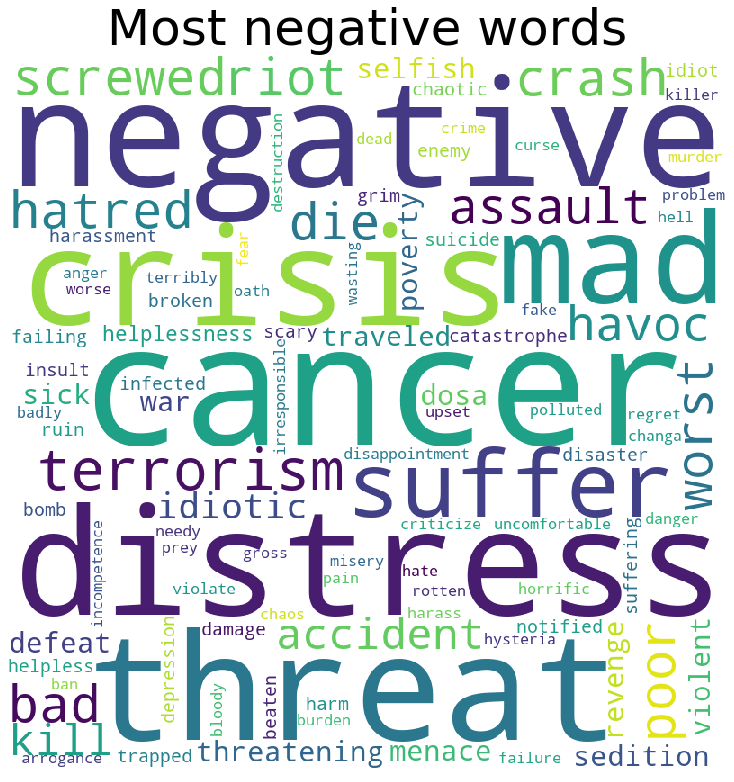

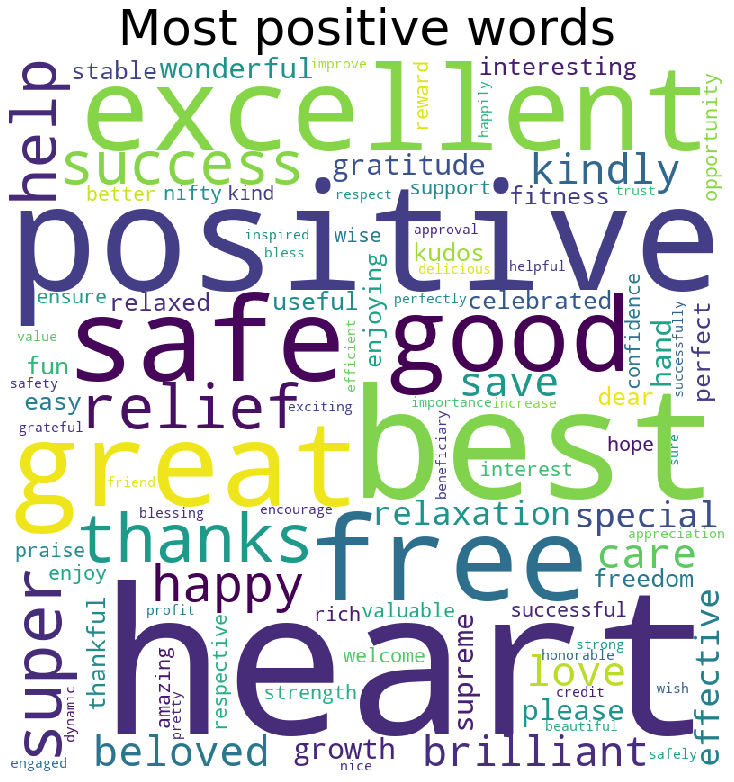

[-1  0 -1  1 -1  1  1 -1 -1  1]


In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df = pd.read_csv('sentiment.csv')
print("Columns in the original dataset:\n")
print(df.columns)


from sklearn.model_selection import train_test_split

X = df['tweet']
y = df['p_score']

one_hot_encoded_label = pd.get_dummies(y)
print(one_hot_encoded_label.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

#second method
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=5).fit(X_train)
print(len(vect.get_feature_names()))
X_train_vectorized = vect.transform(X_train)
feature_names = np.array(vect.get_feature_names())
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

from sklearn.linear_model import LogisticRegression

X_train_vectorized = vect.transform(X_train)
from sklearn.metrics import accuracy_score

c_val =[0.2,0.75, 1, 2, 3, 4, 5, 10,15,20,25]
for c in c_val:
    model = LogisticRegression(C=c,solver='saga')
    model.fit(X_train_vectorized, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, model.predict(vect.transform(X_test)))))

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


def PlotWordCloud(words, title):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white' 
                ).generate(words) 
                                                           
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title, fontsize=50)

    plt.show() 
negative = ''
for word in feature_names[sorted_coef_index[:-101:-1]]:
    negative += word + ' '
PlotWordCloud(negative, 'Most negative words')

positive = ''
for word in feature_names[sorted_coef_index[:100]]:
    positive += word + ' '    
PlotWordCloud(positive, 'Most positive words')

print(model.predict(vect.transform(df.tweet[0:10])))

#df=pd.read_csv('final_sentiment.csv')

df['p_score']=model.predict(vect.transform(df.tweet[0:]))
df.to_csv('sentiment.csv', index=False, encoding="utf-8")


# 4. Data Analysis and Visualization

In [177]:
import pandas as pd
import numpy as np
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


df = pd.read_csv('sentiment.csv')
total=df['p_score'].count()
p=df[df['p_score']== 1 ].count()
nt=df[df['p_score']==0].count()
n=df[df['p_score']== -1 ].count()
print("positive %: ",(p['p_score']/total)*100)
print("neutral %: ",(nt['p_score']/total)*100)
print("negative %: ",(n['p_score']/total)*100)

positive %:  43.459277298108375
neutral %:  9.771726563845226
negative %:  46.76899613804639


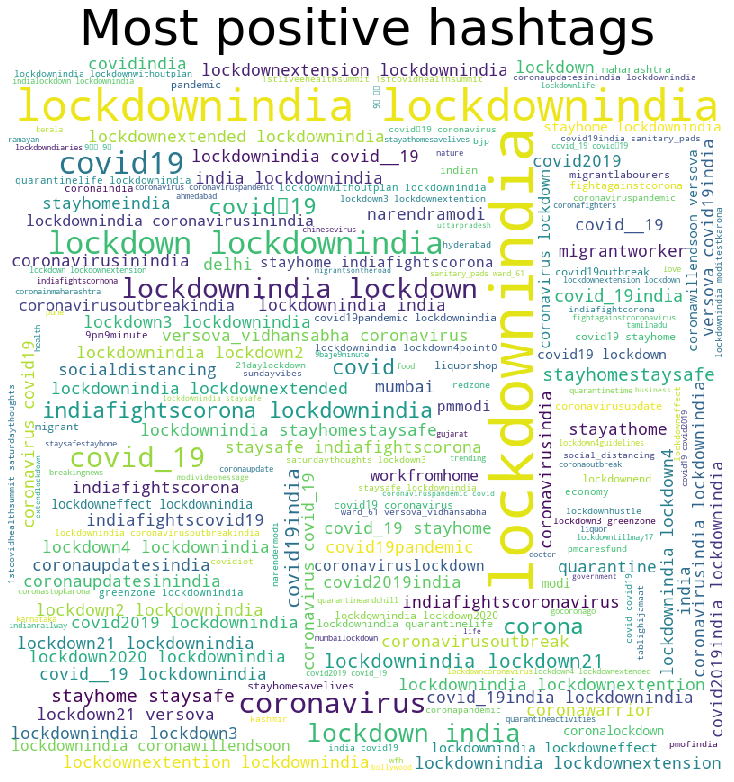

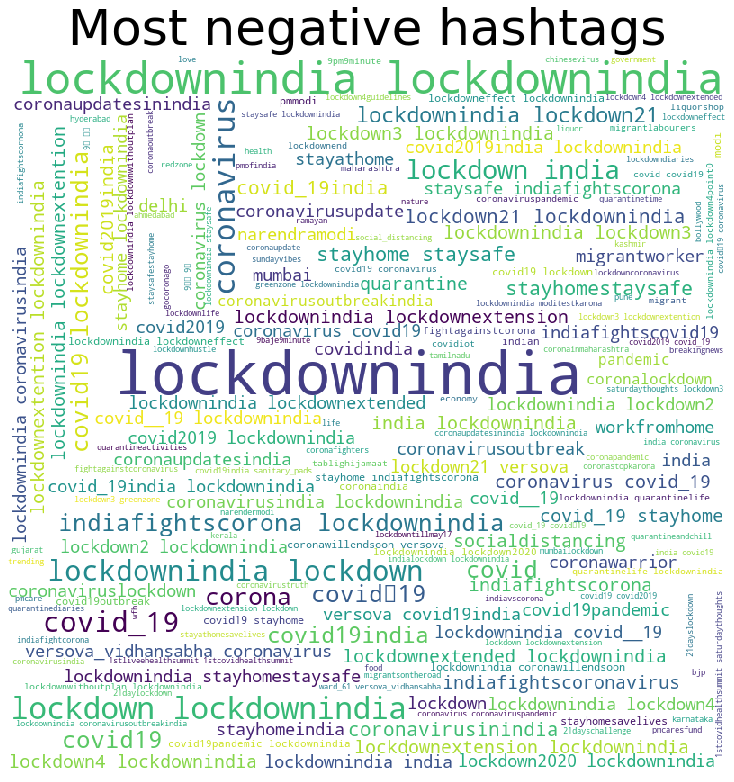

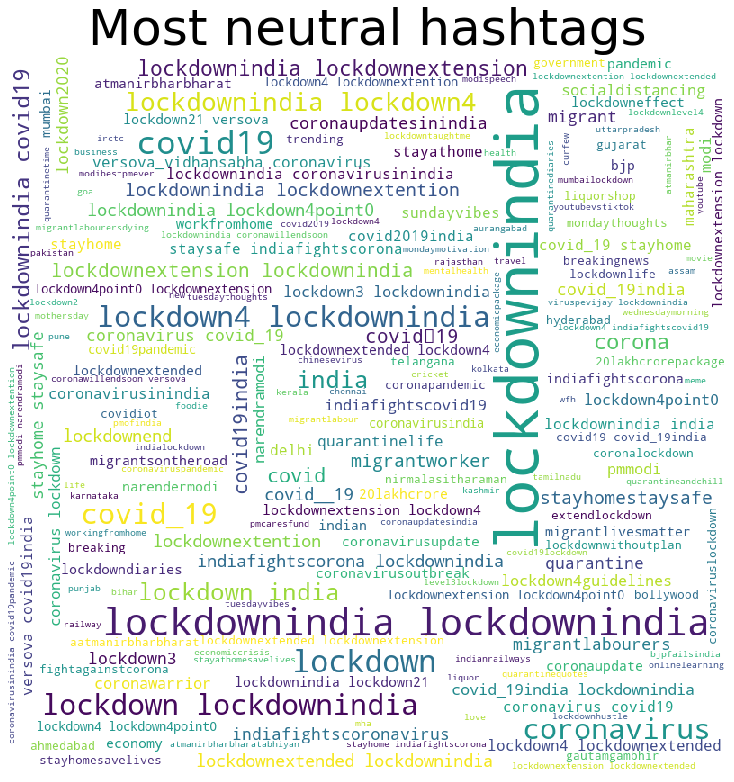

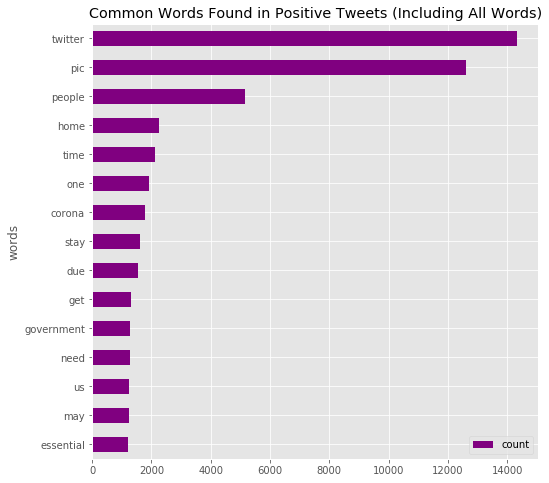

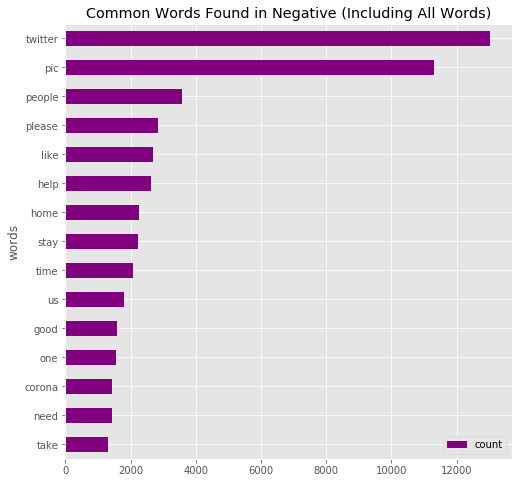

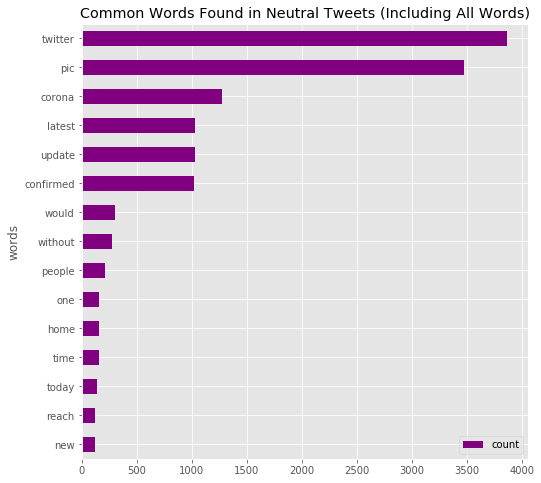

In [173]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import itertools
import collections

df= pd.read_csv('sentiment.csv')
df['hashtags'] = df['hashtags'].str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
neg_hastags=df[df['p_score']==-1]
pos_hastags=df[df['p_score']==1]
nt_hastags=df[df['p_score']==0]
from wordcloud import WordCloud


pos=""
neg=""
nt=""
for i in range(len(pos_hastags)):
    pos+=df.hashtags[i]+" "
for i in range(len(neg_hastags)):
    neg+=df.hashtags[i]+" "
for i in range(len(nt_hastags)):
    nt+=df.hashtags[i]+" "
#print(s)

# lower max_font_size, change the maximum number of word and lighten the background:
def PlotWordCloud(words, title):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white' 
                ).generate(words) 
                                                           
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title, fontsize=50)

    plt.show() 
    
    
PlotWordCloud(pos, 'Most positive hashtags')
PlotWordCloud(neg, 'Most negative hashtags')
PlotWordCloud(nt, 'Most neutral hashtags')

words_in_neg_tweet = [tweet.lower().split() for tweet in pos_hastags.tweet]
words_in_pos_tweet = [tweet.lower().split() for tweet in neg_hastags.tweet]
words_in_nt_tweet = [tweet.lower().split() for tweet in nt_hastags.tweet]

neg_words_no_urls = list(itertools.chain(*words_in_neg_tweet))
pos_words_no_urls = list(itertools.chain(*words_in_pos_tweet))
nt_words_no_urls = list(itertools.chain(*words_in_nt_tweet))

counts_no_neg = collections.Counter(neg_words_no_urls)
counts_no_pos = collections.Counter(pos_words_no_urls)
counts_no_nt = collections.Counter(nt_words_no_urls)

clean_tweets_no_pos = pd.DataFrame(counts_no_pos.most_common(15),
                             columns=['words', 'count'])
clean_tweets_no_neg = pd.DataFrame(counts_no_neg.most_common(15),
                             columns=['words', 'count'])
clean_tweets_no_nt = pd.DataFrame(counts_no_nt.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_pos.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Common Words Found in Positive Tweets (Including All Words)")
plt.show()
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_no_neg.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Common Words Found in Negative (Including All Words)")
plt.show()
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_no_nt.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Common Words Found in Neutral Tweets (Including All Words)")
plt.show() 


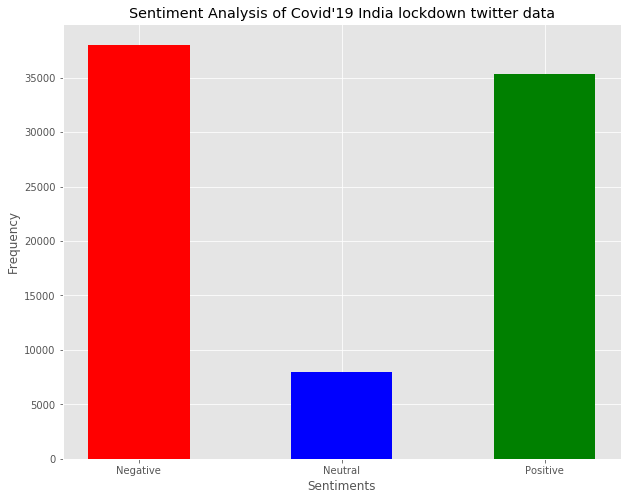

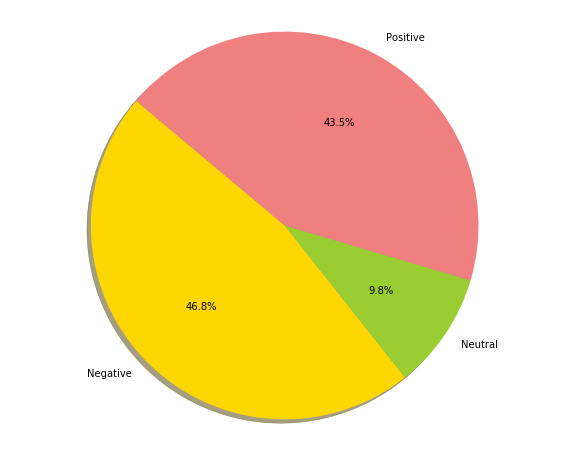

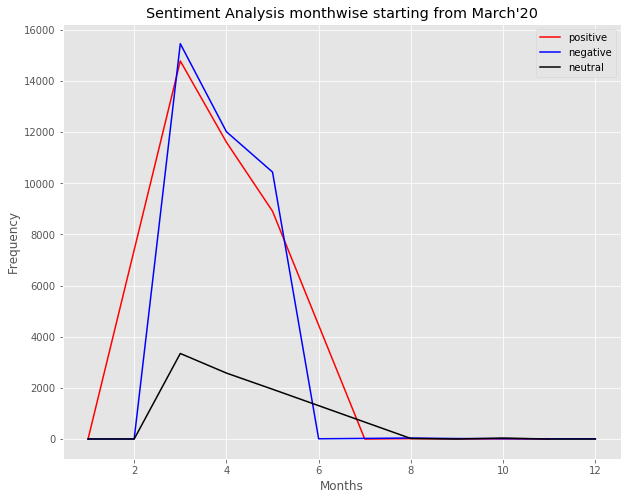

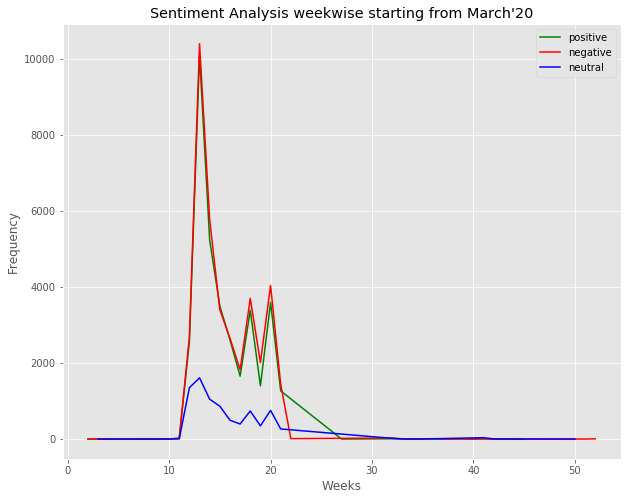

In [174]:
## importing the dataset
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
df = pd.read_csv('sentiment.csv')
df.head()

## plotting the data based on the count of positive , negative and neutral feedback
width = 0.50  
ind = np.arange(4) 
df2 = df.groupby(df["p_score"],as_index=False).count()
plt.style.use('ggplot')
plt.figure(figsize=(10,8))
plt.bar(["Negative","Neutral","Positive"],df2["hashtags"],width,color = ["red","blue","green"])
plt.title("Sentiment Analysis of Covid'19 India lockdown twitter data") 
plt.ylabel("Frequency")
plt.xlabel("Sentiments")
plt.show()

#pie plot
labels = 'Negative', 'Neutral', 'Positive'
sizes = []
sizes = df2["id"].tolist()
colors = ['gold', 'yellowgreen', 'lightcoral']

# Plot
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

ax1.axis('equal')
plt.show()

##Visualization of data monthwise
df["date"] = pd.to_datetime(df["date"])
import datetime
import calendar
df["counter"] = 1;
df["month"] = pd.DatetimeIndex(df["date"]).month
df3 = df[["p_score","month","id"]].groupby(['p_score','month'],as_index=False).count()
positive = df3[df3["p_score"] == 1 ]
negative = df3[df3["p_score"] == -1]
neutral = df3[df3["p_score"] == 0]
fig = plt.subplots(1, figsize=(10, 8))
plt.plot(positive["month"],positive["id"],color="red")
plt.plot(negative["month"],negative["id"],color="blue")
plt.plot(neutral["month"],neutral["id"],color="black")
plt.legend(["positive", "negative","neutral"])
plt.title("Sentiment Analysis monthwise starting from March'20")
plt.xlabel("Months")
plt.ylabel("Frequency")
plt.show()

## Weekwise analysis of the dataset
df["week"] = df['date'].dt.week
df4 = df[["p_score","week","id"]].groupby(["p_score","week"],as_index = False).count()
p_df = df4[df4["p_score"] == 1 ]
n_df = df4[df4["p_score"] == -1]
nn_df = df4[df4["p_score"] == 0]
plt.subplots(1, figsize=(10, 8))
plt.plot(p_df["week"],p_df["id"],color="green")
plt.plot(n_df["week"],n_df["id"],color="red")
plt.plot(nn_df["week"],nn_df["id"],color="blue")
plt.legend(["positive", "negative","neutral"])
plt.title("Sentiment Analysis weekwise starting from March'20")
plt.xlabel("Weeks")
plt.ylabel("Frequency")
plt.show()

In [175]:
# top 10 trending tweets
dataframe = df[df.likes_count>0]
trending_tweets = dataframe.sort_values(by=['likes_count','retweets_count'], ascending=False).head(10)
trending_tweets



,id,created_at,date,time,user_id,username,tweet,replies_count,retweets_count,likes_count,hashtags,p_score,counter,month,week
50543,1242472872724971526,1585063591000,2020-03-24,15:26:31,75246346,sudhirchaudhary,world biggest ever completely locked starting ...,437,2982,19929,[],-1,1,3,13
53935,1241567429349834752,1584847717000,2020-03-22,03:28:37,519321215,ash_stewart_,covid global people death toll curfew,405,3710,10497,['#covid19'],-1,1,3,12
29676,1247012270531440641,1586145868000,2020-04-06,04:04:28,3324117014,iamsaidharamtej,grateful given much space time nature heal pic...,56,662,9794,"['#lockdownindia', '#weareinthistogether', '#n...",1,1,4,15
9230,1257127139322798080,1588557440000,2020-05-04,01:57:20,1247139243408809985,shehbazbadesha,waiting open like pic twitter,633,1530,7568,['#lockdownindia'],1,1,5,19
46970,1242633101500506115,1585101793000,2020-03-25,02:03:13,964875685872525313,prashantkishor,decision maybe right price one behind shaky pr...,2044,1359,7405,"['#lockdownindia', '#covidcrisis']",-1,1,3,13
28749,1247428249224769537,1586245045000,2020-04-07,07:37:25,77732185,drharshvardhan,want help support first two pic twitter,137,1095,7268,"['#fightagainstcorona', '#घरमेंरहेंस्वस्थरहें'...",1,1,4,15
16829,1254433159976030208,1587915146000,2020-04-26,15:32:26,189917061,waglenikhil,satisfied handling survey genuine one save,943,1260,7044,"['#covid_19', '#lockdownindia']",1,1,4,17
63447,1249705263491235842,1586787927000,2020-04-13,14:25:27,81662868,vikramsampath,sad national media role team among mid march c...,156,2114,6961,['#coronaindia'],-1,1,4,16
45599,1242722988698394627,1585123223000,2020-03-25,08:00:23,3259726148,supriyasahuias,wear capes wear pic twitter,179,1328,6697,"['#thankyouheroes', '#coronavirusindia', '#loc...",0,1,3,13
35185,1245222568488914945,1585719170000,2020-04-01,05:32:50,587441372,jaybhanushali0,happy birthday one people whose remember witho...,228,792,6475,"['#lockdownindia', '#birthdaygirl']",1,1,4,14


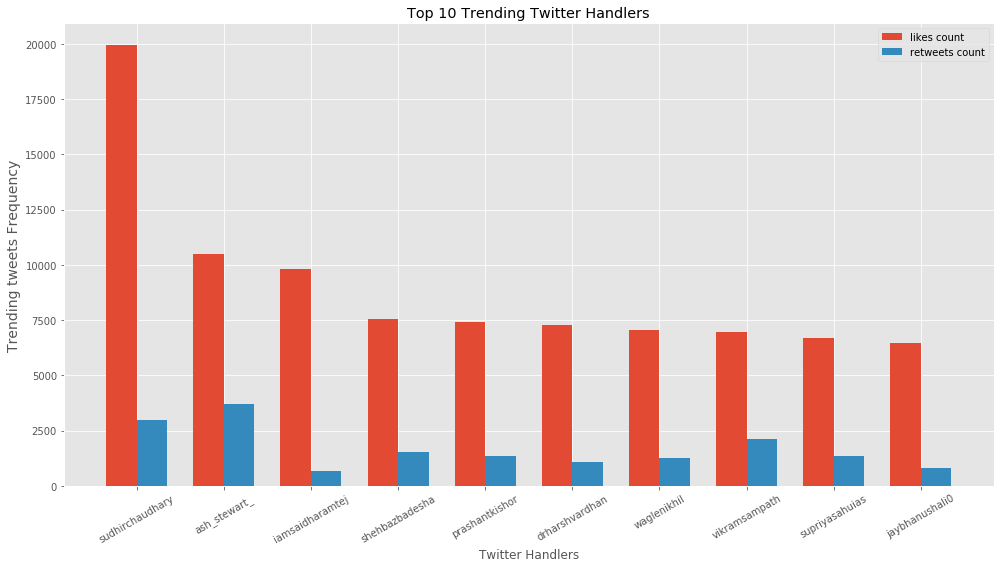

In [176]:
## plotting top 10 trending tweets
likes_count = []
retweets_count = []
replies_count = []
username = []
 
likes_count = trending_tweets['likes_count'].tolist()
retweets_count = trending_tweets['retweets_count'].tolist()
replies_count = trending_tweets['replies_count'].tolist()
username = trending_tweets['username'].tolist()

x = np.arange(len(username))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, likes_count, width, label='likes count')
rects2 = ax.bar(x + width/2, retweets_count, width, label='retweets count')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Trending tweets Frequency',fontsize=14)
ax.set_xlabel('Twitter Handlers')
ax.set_title('Top 10 Trending Twitter Handlers')
ax.set_xticks(x)
ax.set_xticklabels(username ,rotation=30,fontsize=10)
ax.legend()
fig.tight_layout()
plt.show()

# 5.Conclusion

Through sentiment analysis we found that 